In [1]:
import pandas as pd

In [2]:
d1 = pd.read_csv('2018-19.csv')
d2 = pd.read_csv('2019-20.csv')
d3 = pd.read_csv('2020-21.csv')
d4 = pd.read_csv('2021-22.csv')
d5 = pd.read_csv('2022-23.csv')
df = pd.concat([d1,d2,d3,d4,d5])
gids = pd.read_csv('03_data/game_ids.csv')
pwins = pd.read_csv('03_data/playoff_wins.csv')
# average height, weight, and experience
rs = pd.read_csv('03_data/rosters.csv')
print(rs.shape)
# need seasons to get the right id set up 
seasons = pd.read_csv('03_data/seasons.csv')

(10784, 17)


In [3]:
import pandas as pd 

def averaged_data(data,game_ids):
    # takes the raw data and the game_ids as inputs
    # will need to update if new columns are added 
    # player data is averaged by team and season
    # then, the averaged player data is averaged by team and season 
    
    print("player data shape: {}".format(data.shape))
    
    print("merging seasons to the player data via game_id data frame") 
    df2 = data.merge(gids[['GAME_ID','SEASON_YEAR']],how='left',on='GAME_ID').drop_duplicates()
    print("dropping duplicates") 
    print("new shape (should match the old one): {}".format(df2.shape))
    drops = ['GAME_ID','TEAM_ABBREVIATION','TEAM_CITY','PLAYER_NAME','NICKNAME','START_POSITION','COMMENT']
    avg_columns = ['MIN','EFG_PCT','FTA_RATE','TM_TOV_PCT','OREB_PCT','OPP_FTA_RATE','OPP_TOV_PCT','OPP_OREB_PCT']
    print("columns to drop:")
    print(drops)
    print("columns to average:")
    print(avg_columns)
    df3 = df2.drop(drops,axis=1).copy()
    print("Formatting MIN column to float") 
    df3['MIN'] = df3['MIN'].astype(str)
    df3['MIN'] = [x.split(':')[0] for x in df3['MIN']]
    df3['MIN'] = df3['MIN'].mask(df3['MIN']=='nan',0)
    df3['MIN'] = df3['MIN'].astype(float)
    print("creating ID column") 
    df3['ID'] = df3['TEAM_ID'].astype(str)+'_'+df3['PLAYER_ID'].astype(str)+'_'+df3['SEASON_YEAR'].astype(str)
    df3.drop(['TEAM_ID','PLAYER_ID','SEASON_YEAR'],axis=1,inplace=True)
    print("averaging by team, player, and season IDs") 
    df_avg = df3.groupby('ID').mean().reset_index()
    print("creating the team and season id column") 
    id_split = df_avg['ID'].str.split('_')
    team_id = [x[0] for x in id_split]
    season_id = [x[2] for x in id_split]
    team_season = [x+'_'+y for x,y in zip(team_id,season_id)]
    df_avg['TEAM_SEASON'] = team_season
    df_avg.drop('ID',axis=1,inplace=True)
    print("averaging by team and season") 
    df_avg2 = df_avg.groupby('TEAM_SEASON').mean().reset_index()
    
    return df_avg2

import pandas as pd 

def lagged_data(data):
    # takes the averaged data as input 
    # will need to update if new columns are added 
    
    print("averaged data shape: {}".format(data.shape))
    
    print("creating the team and season id") 
    ids = data['TEAM_SEASON'].str.split('_')
    team_id = [x[0] for x in ids]
    season_id = [x[1] for x in ids]
    data['TEAM_ID'] = team_id
    data['SEASON_YEAR'] = season_id
    
    lag_cols = ['TEAM_ID','MIN','EFG_PCT','FTA_RATE','TM_TOV_PCT','OREB_PCT','OPP_EFG_PCT','OPP_FTA_RATE','OPP_TOV_PCT','OPP_OREB_PCT','WIN_PCT']
    
    print("sorting data") 
    data = data.sort_values(['TEAM_SEASON','SEASON_YEAR']).copy()
    
    print("lag columns and TEAM_SEASON:") 
    print(lag_cols)
    
    nolag_cols = []
    for x in list(data.columns):
        if x not in lag_cols:
            nolag_cols.append(x)
    
    tolag = data[lag_cols].copy()
    nolag = data[nolag_cols].copy()
    
    print("no lag columns")
    print(nolag.columns)
    
    print("lagging the data") 
    lagged = tolag.groupby('TEAM_ID').shift(1)
    
    print("adding LAST_YEAR_ prefix to column names")
    lagged = lagged.add_prefix("LS_")
    
    print('adding back the other columns')
    lagged_and = pd.concat([lagged,nolag],axis=1)
    
    return lagged_and

def adding_pwins(data,playoff_wins):
    # takes the lagged data and the playoff wins as input 
    # outputs playoff wins in with the data set 
    
    print("creating TEAM_SEASON in the playoff wins data")
    playoff_wins['TEAM_SEASON'] = playoff_wins['TEAM_ID'].astype(str)+'_'+playoff_wins['YEAR']
    print("merging with the lagged data set")
    data_and_target = data.merge(playoff_wins[['TEAM_SEASON','PO_WINS']],how='left',on='TEAM_SEASON')
    
    return data_and_target

In [4]:
t1 = averaged_data(df,gids)
print("Adding in non-average predictors")
print("adding win percentage from last year")
print("source: playoff wins table")
print("creating TEAM_SEASON in the playoff wins data")
pwins['TEAM_SEASON'] = pwins['TEAM_ID'].astype(str)+'_'+pwins['YEAR']
print("merging with the averaged data set")
t1 = t1.merge(pwins[['TEAM_SEASON','WIN_PCT']],how='left',on='TEAM_SEASON')
t2 = lagged_data(t1)
t3 = adding_pwins(t2,pwins)
print("adding height, weight, and experience")
rs = rs.merge(seasons,how='left',left_on='SEASON',right_on='y1')
rs['TEAM_SEASON'] = rs['TeamID'].astype(str)+'_'+rs['id']
rs['EXP'] = rs['EXP'].mask(rs['EXP']=='R',0)
rs['EXP'] = rs['EXP'].astype(float)
rsh = rs[['TEAM_SEASON','HEIGHT_INCHES','WEIGHT','EXP']].groupby('TEAM_SEASON').mean().reset_index()
t4 = t3.merge(rsh,how='left',on='TEAM_SEASON')
print(t4.shape)
t4.head()

player data shape: (149068, 18)
merging seasons to the player data via game_id data frame
dropping duplicates
new shape (should match the old one): (149068, 19)
columns to drop:
['GAME_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_NAME', 'NICKNAME', 'START_POSITION', 'COMMENT']
columns to average:
['MIN', 'EFG_PCT', 'FTA_RATE', 'TM_TOV_PCT', 'OREB_PCT', 'OPP_FTA_RATE', 'OPP_TOV_PCT', 'OPP_OREB_PCT']
Formatting MIN column to float
creating ID column
averaging by team, player, and season IDs
creating the team and season id column
averaging by team and season
Adding in non-average predictors
adding win percentage from last year
source: playoff wins table
creating TEAM_SEASON in the playoff wins data
merging with the averaged data set
averaged data shape: (150, 11)
creating the team and season id
sorting data
lag columns and TEAM_SEASON:
['TEAM_ID', 'MIN', 'EFG_PCT', 'FTA_RATE', 'TM_TOV_PCT', 'OREB_PCT', 'OPP_EFG_PCT', 'OPP_FTA_RATE', 'OPP_TOV_PCT', 'OPP_OREB_PCT', 'WIN_PCT']
no lag colum

,LS_MIN,LS_EFG_PCT,LS_FTA_RATE,LS_TM_TOV_PCT,LS_OREB_PCT,LS_OPP_EFG_PCT,LS_OPP_FTA_RATE,LS_OPP_TOV_PCT,LS_OPP_OREB_PCT,LS_WIN_PCT,TEAM_SEASON,SEASON_YEAR,PO_WINS,HEIGHT_INCHES,WEIGHT,EXP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1610612737_2018-19,2018-19,0,79.866667,224.000000,3.466667
1,14.872590,0.505529,0.265402,0.153509,0.244610,0.549571,0.408114,0.130150,0.209078,0.354,1610612737_2019-20,2019-20,0,78.812500,217.250000,3.687500
2,16.892685,0.482060,0.282884,0.150011,0.207574,0.536856,0.325477,0.158112,0.238436,0.299,1610612737_2020-21,2020-21,10,78.235294,216.058824,3.823529
3,18.130806,0.513201,0.315347,0.142886,0.236227,0.529979,0.276183,0.119988,0.215450,0.569,1610612737_2021-22,2021-22,1,78.352941,212.882353,4.411765
4,14.115737,0.541423,0.267708,0.133476,0.190964,0.550785,0.250240,0.127187,0.188953,0.524,1610612737_2022-23,2022-23,2,78.352941,212.705882,2.823529


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns  # data visualization library  
import matplotlib.pyplot as plt
import time

In [6]:
plot_data = t4

In [7]:
plot_data['PO_WINS'].value_counts(dropna=False).sort_index()

0     78
1     17
2     10
3      5
4      1
5      3
6      7
7      9
8      2
9      2
10     4
11     2
13     1
14     4
16     5
Name: PO_WINS, dtype: int64

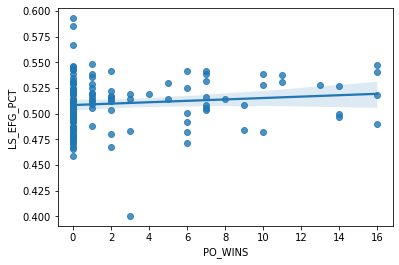

In [8]:
sns.regplot(data=plot_data,x='PO_WINS',y='LS_EFG_PCT',)
plt.show()

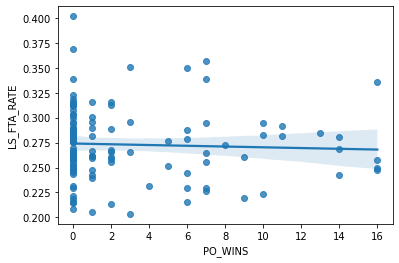

In [9]:
sns.regplot(data=plot_data,x='PO_WINS',y='LS_FTA_RATE',)
plt.show()

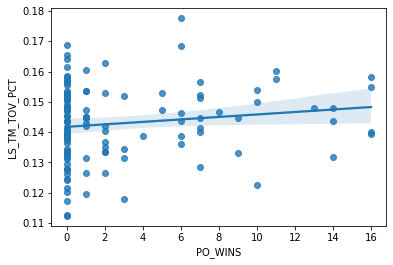

In [10]:
sns.regplot(data=plot_data,x='PO_WINS',y='LS_TM_TOV_PCT',)
plt.show()

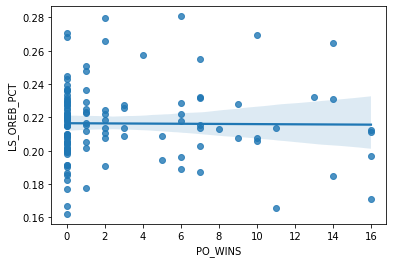

In [11]:
sns.regplot(data=plot_data,x='PO_WINS',y='LS_OREB_PCT',)
plt.show()

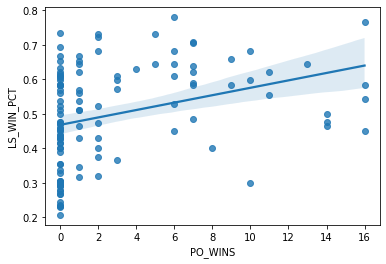

In [12]:
sns.regplot(data=plot_data,x='PO_WINS',y='LS_WIN_PCT',)
plt.show()

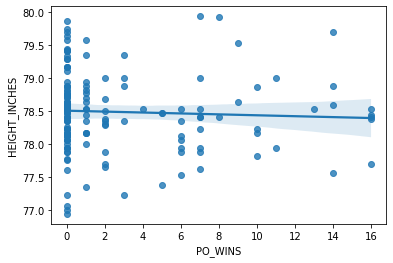

In [13]:
sns.regplot(data=plot_data,x='PO_WINS',y='HEIGHT_INCHES',)
plt.show()

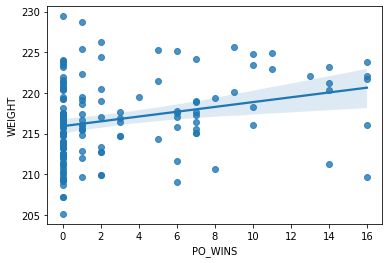

In [14]:
sns.regplot(data=plot_data,x='PO_WINS',y='WEIGHT',)
plt.show()

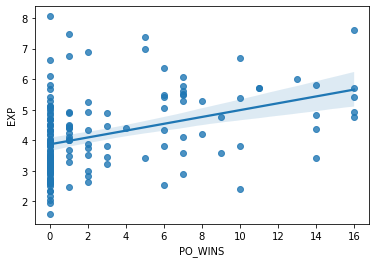

In [15]:
sns.regplot(data=plot_data,x='PO_WINS',y='EXP',)
plt.show()

In [16]:
# what if I try to attack this as a category problem 

In [17]:
def cats(w):
    if w<4:
        return 'R1/Lottery'
    elif 4<=w<8:
        return 'Second Round'
    elif 8<w<=12:
        return 'Conf. Finals'
    elif 12<w<=16:
        return 'Finals'

In [18]:
plot_data['PO_WINS_CAT'] = [cats(x) for x in plot_data['PO_WINS']]

C:\ProgramData\Anaconda3\envs\w2\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


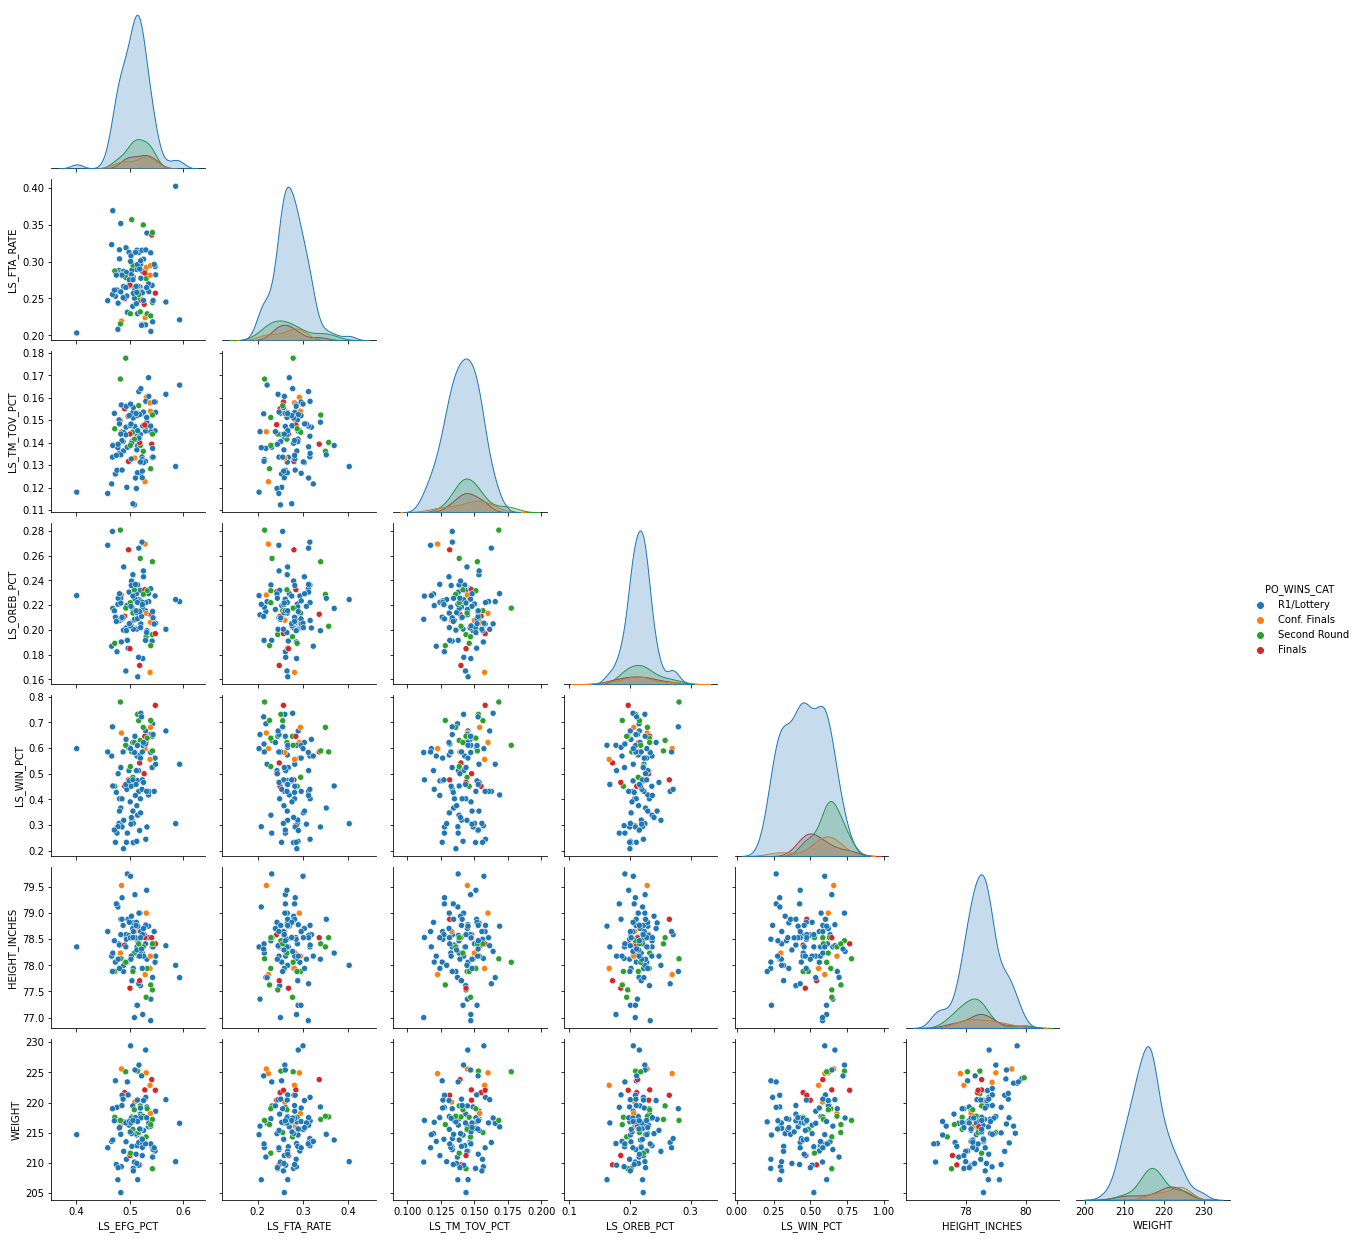

In [19]:
sns.pairplot(plot_data[['LS_EFG_PCT','LS_FTA_RATE','LS_TM_TOV_PCT','LS_OREB_PCT','LS_WIN_PCT','PO_WINS_CAT','HEIGHT_INCHES','WEIGHT']],hue='PO_WINS_CAT',corner=True)
plt.show()

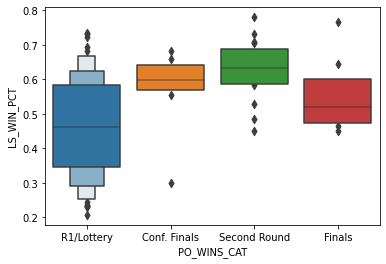

In [20]:
sns.boxenplot(data=plot_data,x='PO_WINS_CAT',y='LS_WIN_PCT')
plt.show()

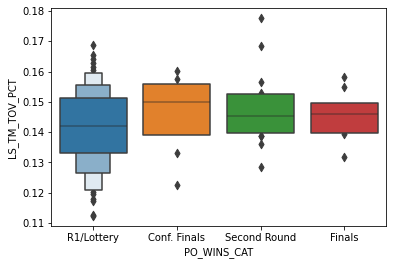

In [21]:
sns.boxenplot(data=plot_data,x='PO_WINS_CAT',y='LS_TM_TOV_PCT')
plt.show()

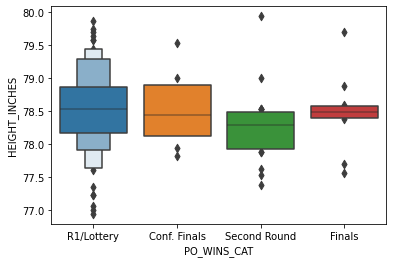

In [22]:
sns.boxenplot(data=plot_data,x='PO_WINS_CAT',y='HEIGHT_INCHES')
plt.show()

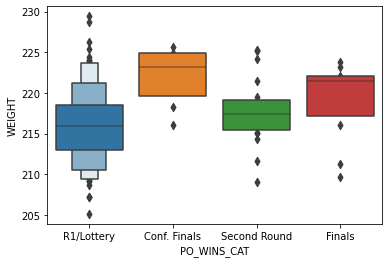

In [23]:
sns.boxenplot(data=plot_data,x='PO_WINS_CAT',y='WEIGHT')
plt.show()

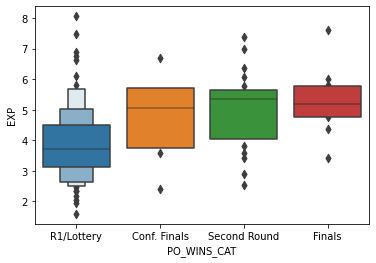

In [24]:
sns.boxenplot(data=plot_data,x='PO_WINS_CAT',y='EXP')
plt.show()